Systematic Uncertainty Modelling
===

In the `Neural_Likelihood_Ratio_Estimation.ipynb` notebook, we left out the nuisance parameter piece of the parameterized density ratio decomposition:

$$g_c(x|\alpha) = \frac{p_c(x|\alpha)}{p_c(x)} = \prod_m \frac{p_c(x|\alpha_m^{eval})}{p_c(x)}$$

where the second equality assumes that the effect of various sources of uncertainty in the model can be factorized. This is another density ratio estimation problem, but instead of training m $\alpha-$parameterized NNs, we use a HistFactory-style interpolation generalized to a per-event formulation:

$$\frac{p_c(x|\alpha_m^{eval})}{p_c(x)} = \begin{cases}
    \left(\frac{p_c(x|\alpha_m^+)}{p_c(x)}\right)^{\alpha_m^\text{eval}}& \alpha_m^\text{eval}>1\\
    1+\sum_{n=1}^6c_n\cdot (\alpha_m^\text{eval})^n& -1\leq\alpha_m^\text{eval}\leq 1\\
    \left(\frac{p_c(x|\alpha_m^-)}{p_c(x)}\right)^{-\alpha_m^\text{eval}}& \alpha_m^\text{eval}<-1\\
    \end{cases}$$

where $\alpha=\{\alpha_m^{eval}\}$ and for each nuisance parameter $m$, we have three simulation models - $p_c(x), p_c(x|\alpha_m^+), p_c(x|\alpha_m^-)$. Naturally, this still requires NNs to estimate the density ratios:

$$\frac{p_c(x|\alpha_m^+)}{p_c(x)} \, , \frac{p_c(x|\alpha_m^-)}{p_c(x)}$$

**These are the density ratios that we will estimate using NNs in this notebook.**
Two ratios corresponding to each $\alpha_m^\pm$ will be trained for each systematic uncertainty indexed by $m$ and for each channel $c$ to build the final parameterized model, 

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot G_c(\alpha) \cdot \nu_c \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

The full workflow for building $\mu, \alpha-$parameterized density ratios is represented in the flowchart below:

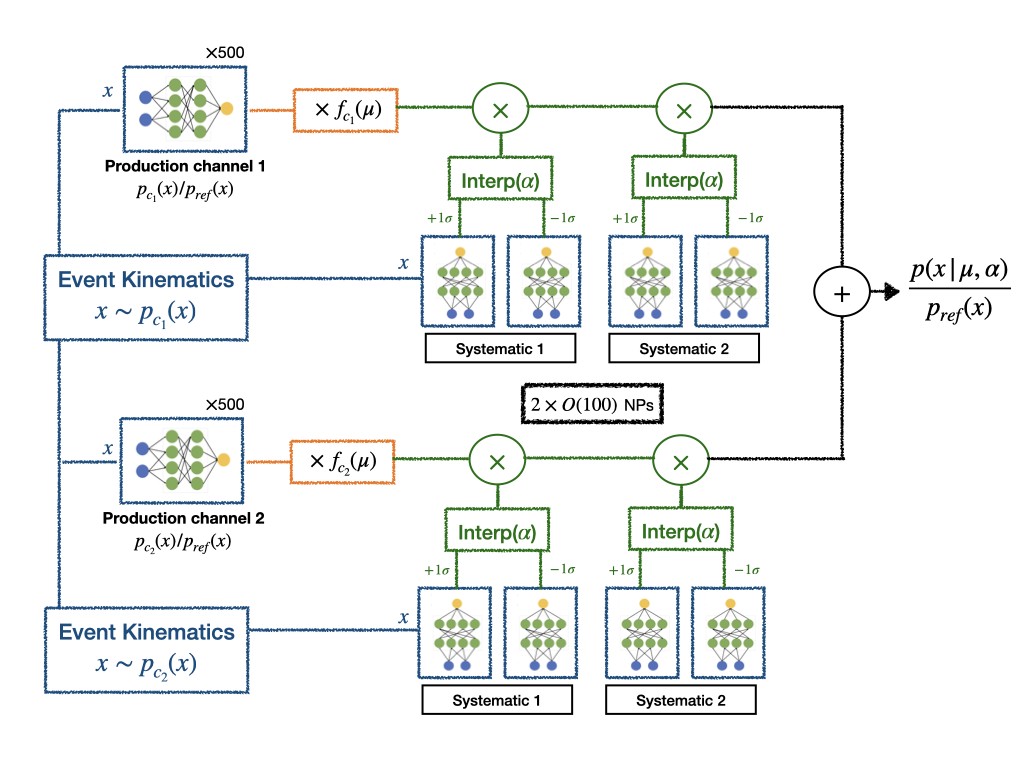

In [29]:
import os, sys, importlib
sys.path.append('../')

import nsbi_common_utils
from nsbi_common_utils import plotting, training
from nsbi_common_utils.training import TrainEvaluate_NN, TrainEvaluatePreselNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
import pickle

from coffea.analysis_tools import PackedSelection

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

hep.style.use(hep.style.ATLAS)

In [30]:
# Systematics and which samples are affected by which systematics
dict_systs = {'ttbar_scale': {'process':['ttbar'], 'directions':['up','down']},
              'pt_scale': {'process':['ttbar', 'single_top_t_chan','wjets'], 'directions':['up']}}

dict_systs = {'ttbar_scale': {'process':['ttbar'], 'directions':['up','down']}}

list_syst = [key for key in dict_systs]

# # Features to use for training NNs. Only use lepton kinematics - use log pT for reduced spread
# columns = ['log_lepton_pt', 'lepton_eta', 'lepton_phi', 'log_H_T', 'n_jets']
# columns_scaling = ['log_lepton_pt', 'lepton_eta', 'lepton_phi', 'log_H_T']

# Features to use for training NNs. Only use lepton kinematics - use log pT for reduced spread
columns = ['log_lepton_pt', 'lepton_eta', 'lepton_phi', 'log_H_T']
columns_scaling = ['log_lepton_pt', 'lepton_eta', 'lepton_phi', 'log_H_T']

# # Features to use for training NNs. Only use lepton kinematics - use log pT for reduced spread
# columns = ['log_lepton_pt', 'lepton_eta', 'lepton_phi']
# columns_scaling = ['log_lepton_pt', 'lepton_eta', 'lepton_phi']


In [31]:
# Load the datasets from pre-processed input
path_prefix = '/home/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/'
saved_data = f'{path_prefix}cached_data/'

dataset_incl = pd.read_hdf(f"{saved_data}dataset_inclusive.h5", key="dataset", mode='r')
presel_score_incl = np.load(f"{saved_data}presel_score_incl.npy")

dataset_incl['presel_score'] = presel_score_incl

preselection_cut_lower = -0.6
# preselection_cut_lower = -0.0

dataset_SR = dataset_incl[(dataset_incl.presel_score>=preselection_cut_lower)].copy()
dataset_SR = dataset_SR[(dataset_SR.lepton_pt<=200.0)].copy()
dataset_SR = dataset_SR[(dataset_SR.H_T<=1000.0)].copy()

dataset_CR = dataset_incl[(dataset_incl.presel_score<preselection_cut_lower)].copy()


In [32]:
# Get the dictionary of labels to processes
labels_dict = np.load(f"{saved_data}labels_dictionary.npy", allow_pickle=True).item()

Signal and Control Regions
===

The SR needs additional density ratios to be trained, whereas the CR follows the standard procedure of template histogram building.

In [33]:
# Load the Control Region observable
with open(f"{saved_data}hist_CR_ttbar.pkl", "rb") as fp:
    hist_CR = pickle.load(fp)

bins_CR = np.load(f"{saved_data}CRbins.npy")

min_presel_bin = bins_CR[0]
max_presel_bin = bins_CR[-1]

In [34]:
hist_var = {}

for process in labels_dict:
    
    hist_var[process] = {}
    mask_process = (dataset_CR.type==process)
    
    for syst in dict_systs:

        hist_var[process][syst] = {}

        for direction in ['up', 'down']:

            hist_var[process][syst][direction] = {}
        
            if (process not in dict_systs[syst]['process']) | (direction not in dict_systs[syst]['directions']):
                hist_var[process][syst][direction] = np.ones_like(hist_CR[process])

            else:
                mask_syst = (dataset_CR.syst_labels==syst+'_'+direction)
                mask_syst_process = mask_process & mask_syst
                
                hist_var[process][syst][direction] = np.histogram(np.clip(dataset_CR[mask_syst_process]['presel_score'].ravel(), 
                                                                    min_presel_bin, max_presel_bin), 
                                                                    weights = dataset_CR[mask_syst_process]['weights'].ravel(),
                                                                    bins = bins_CR)[0]/hist_CR[process]

print(hist_var)

{'ttbar': {'ttbar_scale': {'up': array([1.05110718, 1.02962483, 0.91286065, 0.95168986, 0.94111488,
       0.96444637, 0.97297215, 0.97989314, 0.96542496]), 'down': array([1.0028908 , 1.00995417, 0.95835706, 1.0026827 , 0.97945387,
       1.06033867, 1.06120468, 1.07553399, 1.05167616])}}, 'single_top_t_chan': {'ttbar_scale': {'up': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'down': array([1., 1., 1., 1., 1., 1., 1., 1., 1.])}}, 'wjets': {'ttbar_scale': {'up': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'down': array([1., 1., 1., 1., 1., 1., 1., 1., 1.])}}}


In [35]:
# Save the Control Region variation histogram
with open(f"{saved_data}hist_CR_variations.pkl", "wb") as fp:
    pickle.dump(hist_var, fp)

In [36]:
# Normalizing the training weights post preselection 
weights_normed      = dataset_SR['weights'].to_numpy().copy()
weights             = dataset_SR['weights'].to_numpy().copy()

for syst_sample in np.unique(dataset_SR["syst_labels"]):

    mask_syst = dataset_SR.syst_labels==syst_sample
    
    for key in labels_dict:

        mask_syst_process                     = mask_syst & (dataset_SR.type==key)
        weights_normed[mask_syst_process]    /= weights[mask_syst_process].sum()

dataset_SR['weights_normed'] = weights_normed

Density ratio training
===

Now we train the NNs for $\frac{p_c}{p_{ref}}(x)$ density ratios to build the full model. Our choice of reference hypothesis, motivated by the search-oriented mixture model described above, is: 

$$p_{ref}(x) = p_\text{ttbar}(x) = \frac{1}{\nu_\text{ttbar}} \frac{d\sigma_\text{ttbar}}{dx} $$

gives the POI $\mu-$parameterized model:

$$\sum_c \left[f_c(\mu) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)} \right]= \mu + \frac{p_\text{wjets}\left(x\right)}{p_\text{ttbar}(x)} + \frac{p_\text{single top}\left(x\right)}{p_\text{ttbar}(x)}$$

The task of estimating the $\mu-$parameterized density ratio is thus reduced to estimating two $\mu-$independent density ratios $\frac{p_\text{single top}}{p_{t\bar{t}}}(x)$ and $\frac{p_\text{wjets}}{p_{t\bar{t}}}(x)$ mixed together with an analytical parameterization (hence the name mixture model).

In [79]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import TrainEvaluate_NN


ref_processes = ['ttbar']
mask_ref = np.isin(dataset_SR.type, ref_processes) & (dataset_SR.syst_labels=='nominal')

dataset_syst_process = {}
NN_training_syst_process = {}

rnd_seed_traintestsplit = 42 # can also be randomized, fixed for now

for process in labels_dict:
    
    NN_training_syst_process[process] = {}

    mask_process = (dataset_SR.type==process)
    
    for syst in dict_systs:

        if process not in dict_systs[syst]['process']:
            print(f"Nothing to train for {process} in {syst} uncertainty")
            continue
            
        NN_training_syst_process[process][syst] = {}
        
        for direction in dict_systs[syst]['directions']:
            
            # Save paths
            top_path = f'{path_prefix}output_training_systematics/'

            output_name = f'{process}_{syst}_{direction}'
            output_dir = f'{top_path}general_output_{process}_{syst}_{direction}'
            path_to_ratios = f'{top_path}output_ratios_{process}_{syst}_{direction}/'
            path_to_figures = f'{top_path}output_figures_{process}_{syst}_{direction}/'
            path_to_models = f'{top_path}output_model_params_{process}_{syst}_{direction}/'
            
            mask_process_syst = (dataset_SR.syst_labels==syst+'_'+direction) & mask_process
            # mask_nominal = (dataset_SR.syst_labels=='nominal') & mask_process

            if True not in np.unique(mask_process_syst):
                print(syst)
                print(process)
            # Build a training dataset for the training of p_<process_type>/p_<ref_processes> density ratio
            dataset_syst_process = pd.concat([dataset_SR[mask_process_syst].copy(), 
                                                            dataset_SR[mask_ref].copy()])

            mask_num_hypothesis = (dataset_syst_process.syst_labels==syst+'_'+direction)
            dataset_syst_process['train_labels'] = 0
            dataset_syst_process.loc[mask_num_hypothesis, 'train_labels'] = 1
            print(dataset_syst_process[dataset_syst_process.train_labels==1]['weights'].sum()/dataset_syst_process[dataset_syst_process.train_labels==0]['weights'].sum())
            NN_training_syst_process[process][syst][direction] = TrainEvaluate_NN(dataset_syst_process, 
                                                                                   dataset_syst_process['weights_normed'],
                                                                                   dataset_syst_process['train_labels'],
                                                                                   columns, 
                                                                                   columns_scaling, rnd_seed_traintestsplit,
                                                                                   [syst+'_'+direction, process], output_dir, output_name, 
                                                                                    path_to_figures=path_to_figures,
                                                                                    path_to_ratios=path_to_ratios, 
                                                                                    path_to_models=path_to_models)
                


0.9997006201990541
1.0051842172477652
Nothing to train for single_top_t_chan in ttbar_scale uncertainty
Nothing to train for wjets in ttbar_scale uncertainty


In [80]:
dataset_SR[mask_ref].weights.sum()

833737.9812098659



 Training for ttbar_scale


Sum of weights of class 0: 0.7000006647890075
Sum of weights of class 1: 0.7000004626481047
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                │ (None, 1000)           │         5,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,007,001 (3.84 MB)

 Trainable params: 1,007,001 (3.84 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks


2025-05-26 16:33:59.736444: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_1', 8 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 16 bytes spill stores, 20 bytes spill loads



Finished Training
/home/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/output_training_systematics/output_model_params_ttbar_ttbar_scale_up/model_scaler.bin


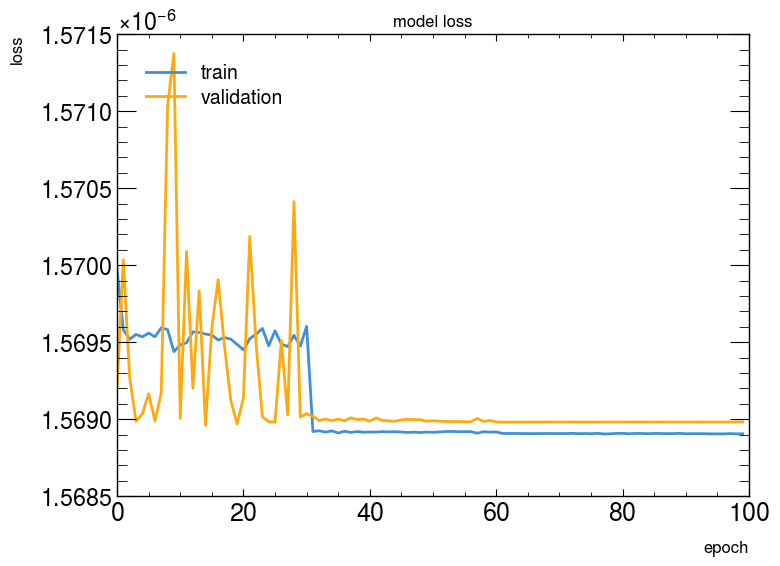

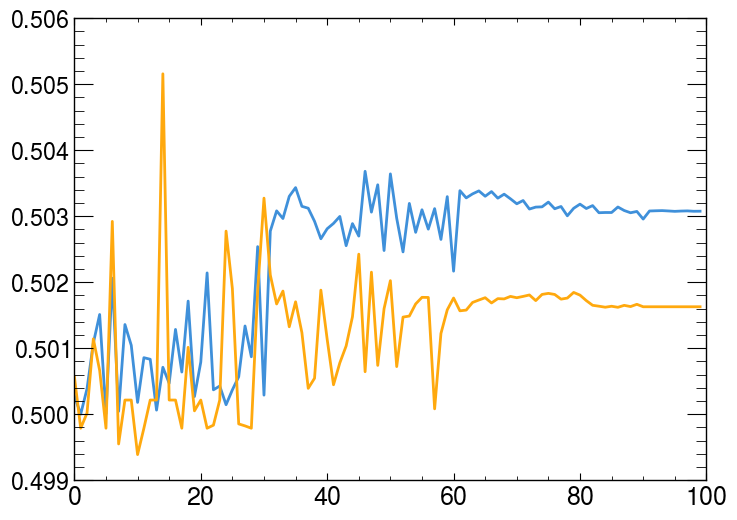

8284/8284 - 4s - 541us/step
19328/19328 - 10s - 517us/step
27612/27612 - 14s - 514us/step
The sum of PDFs is 0.9999516852834973
Sum of weights of class 0: 0.7000006647890075
Sum of weights of class 1: 0.7000004639144165
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_69 (Dense)                │ (None, 1000)           │         5,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,007,001 (3.84 MB)

 Trainable params: 1,007,001 (3.84 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks


2025-05-26 16:40:17.955812: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_1', 8 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 16 bytes spill stores, 20 bytes spill loads



Finished Training
/home/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/output_training_systematics/output_model_params_ttbar_ttbar_scale_down/model_scaler.bin


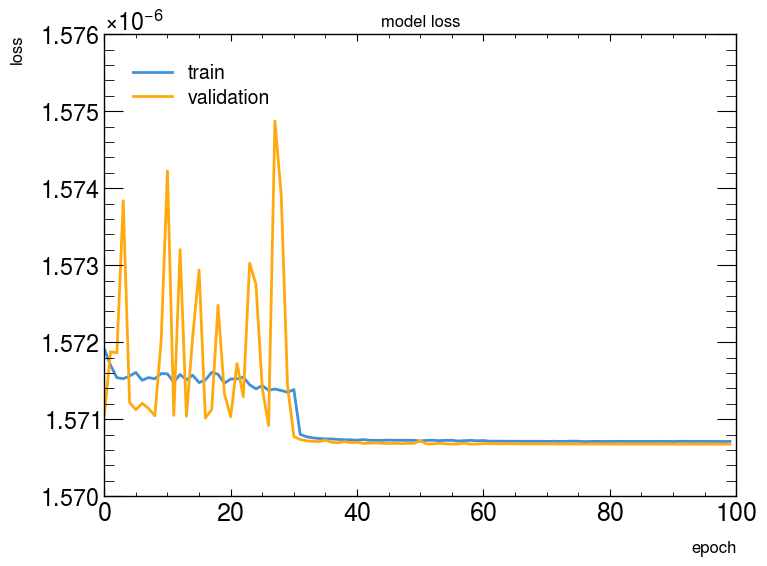

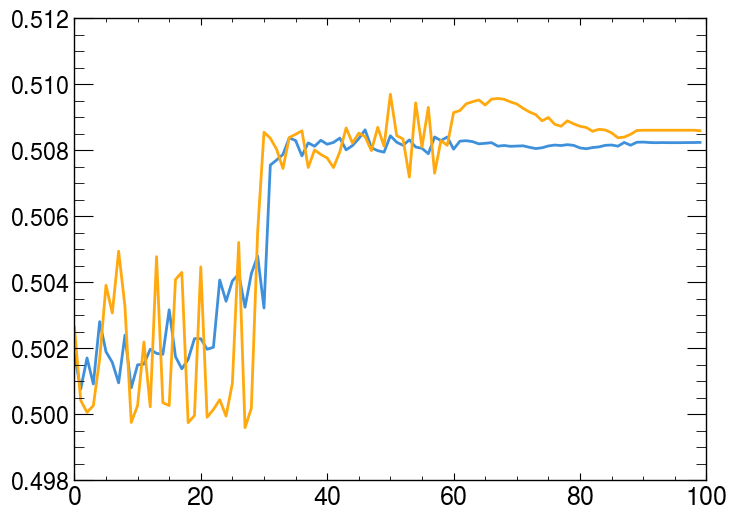

8273/8273 - 5s - 548us/step
19303/19303 - 10s - 521us/step
27575/27575 - 15s - 536us/step
The sum of PDFs is 0.9994893169788289


 Training for ttbar_scale


Nothing to train for single_top_t_chan in ttbar_scale uncertainty


 Training for ttbar_scale


Nothing to train for wjets in ttbar_scale uncertainty


<Figure size 800x600 with 0 Axes>

In [81]:
doCalibration=False

for process in labels_dict:
    
    for syst in dict_systs:

        print(f"\n\n Training for {syst}\n\n")

        if process not in dict_systs[syst]['process']:
            print(f"Nothing to train for {process} in {syst} uncertainty")
            continue
        
        for direction in dict_systs[syst]['directions']:

            # Train the density ratio NN
            NN_training_syst_process[process][syst][direction].train (   hidden_layers        = 2, 
                                                                         neurons              = 1000, 
                                                                         number_of_epochs     = 100, 
                                                                         batch_size           = 256, 
                                                                         learning_rate        = 0.1, 
                                                                         scalerType           = 'MinMax', 
                                                                         calibration          = doCalibration, 
                                                                         num_bins_cal         = 100, 
                                                                         callback             = True, 
                                                                         callback_patience    = 30, 
                                                                         callback_factor      = 0.01,
                                                                         verbose              = 0          )    
            
            NN_training_syst_process[process][syst][direction].test_normalization ( )    
            


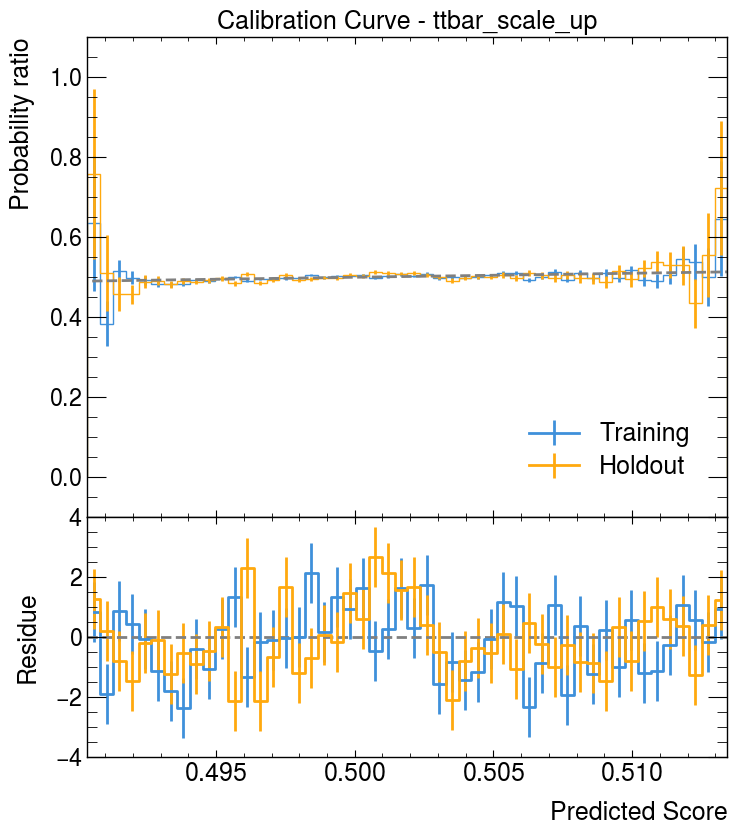

observable not recognized


<Figure size 800x600 with 0 Axes>

In [82]:
num_bins_cal = 50
NN_training_syst_process["ttbar"]["ttbar_scale"]["up"].make_calib_plots(nbins=num_bins_cal, observable='score')

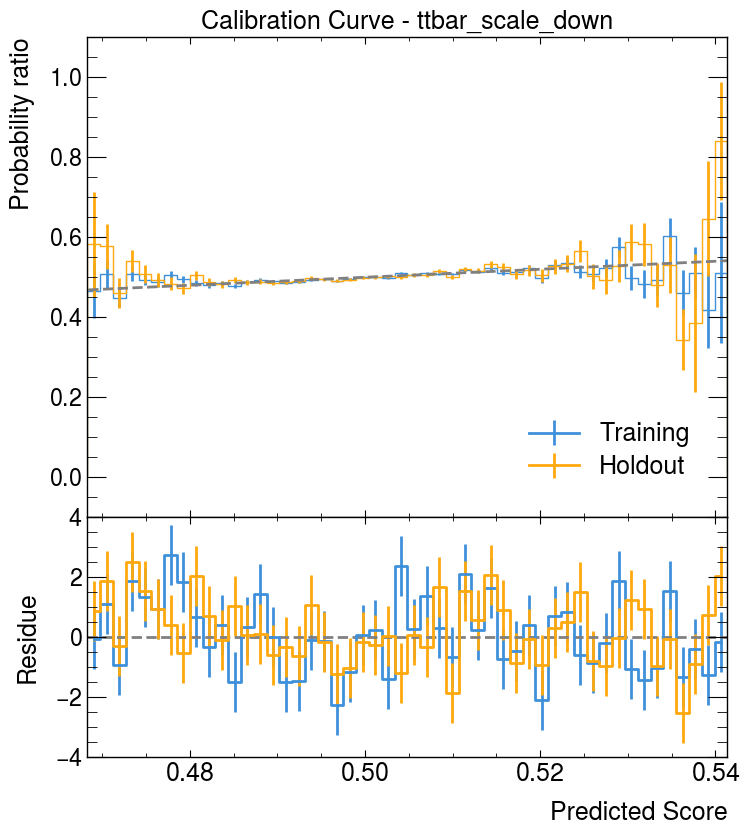

observable not recognized


<Figure size 800x600 with 0 Axes>

In [83]:
num_bins_cal = 50
NN_training_syst_process["ttbar"]["ttbar_scale"]["down"].make_calib_plots(nbins=num_bins_cal, observable='score')

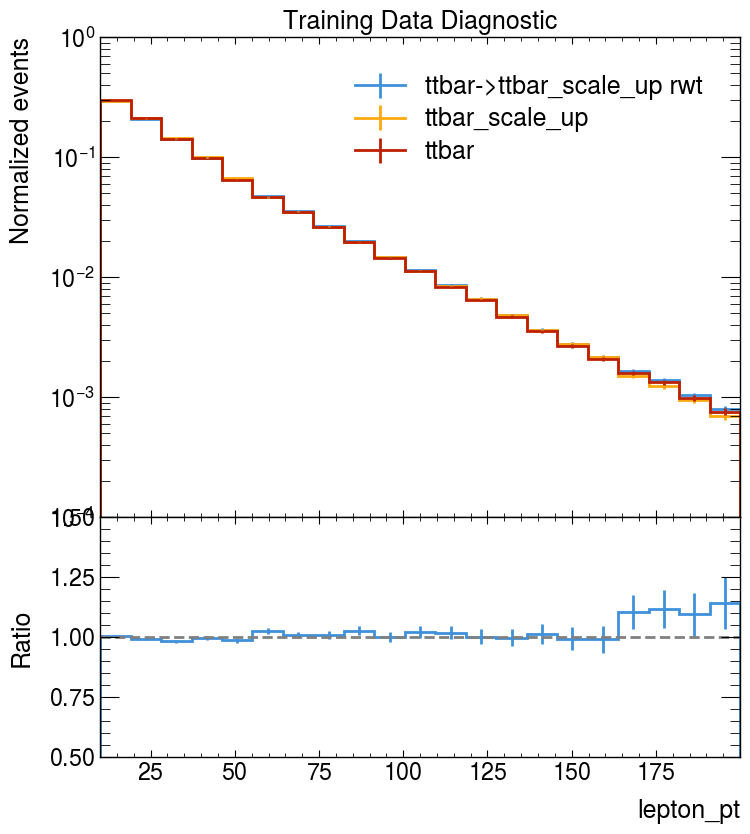

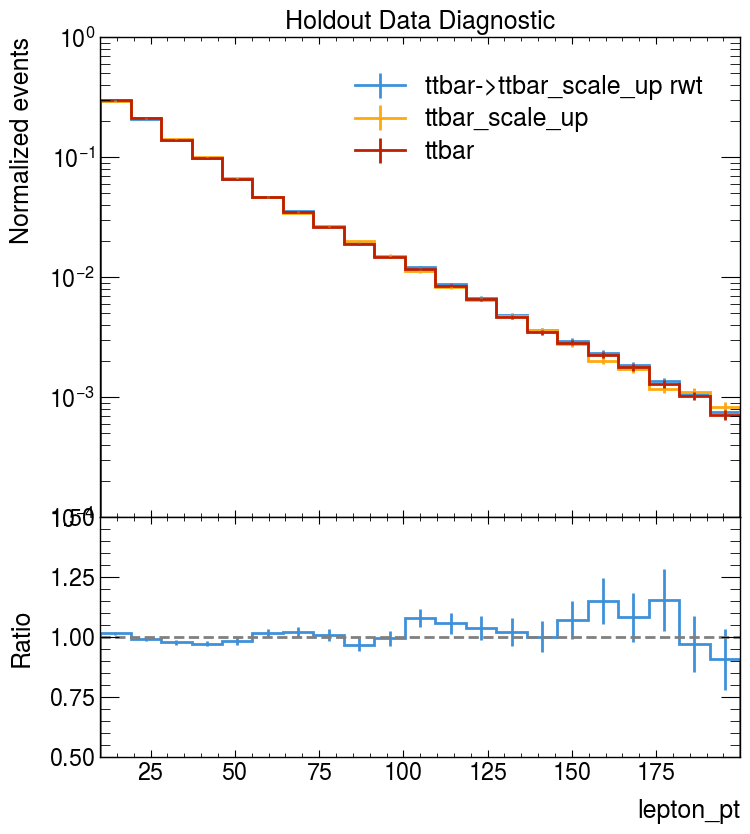

<Figure size 800x600 with 0 Axes>

In [84]:
variables_to_plot=['lepton_pt'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["ttbar"]["ttbar_scale"]["up"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


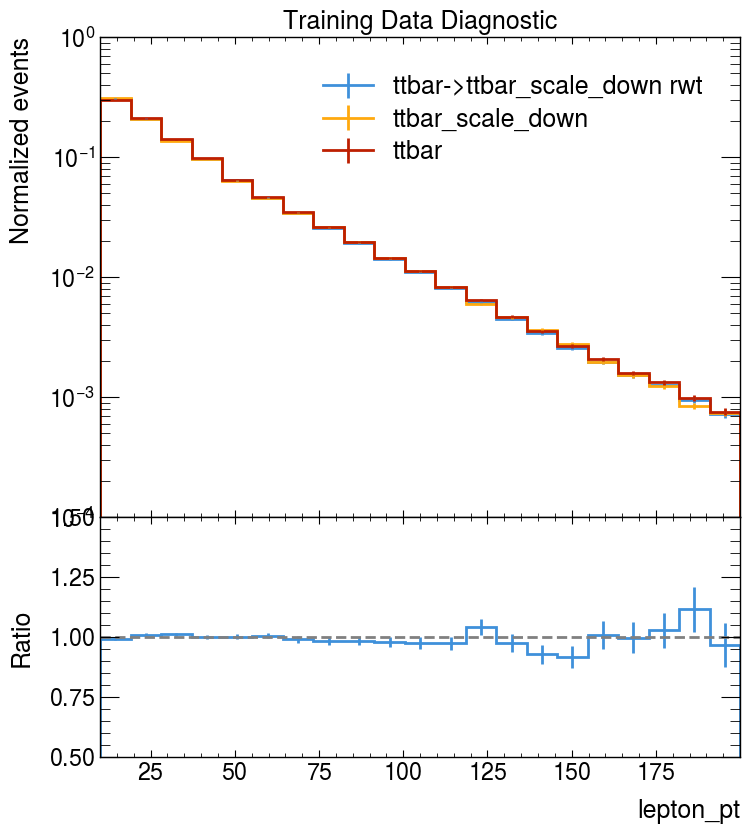

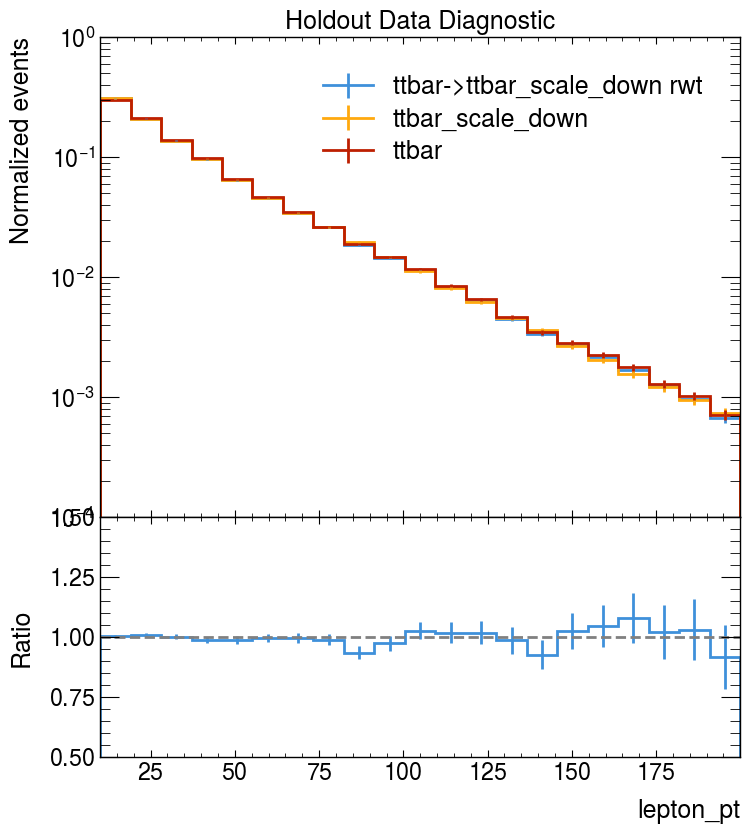

<Figure size 800x600 with 0 Axes>

In [85]:
variables_to_plot=['lepton_pt'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["ttbar"]["ttbar_scale"]["down"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [86]:
dataset_eval = pd.read_hdf(f"{saved_data}dataset_preselected_nominal_ttbar.h5", key="dataset", mode='r')

for process in labels_dict:
    
    for syst in dict_systs:

        if process not in dict_systs[syst]['process']:
            print(f"Nothing to evaluate for {process} in {syst} uncertainty")
            continue
        
        for direction in dict_systs[syst]['directions']:

            # Evaluate the density ratios p_alpha^\pm/p_nom for the nominal dataset
            NN_training_syst_process[process][syst][direction].evaluate_and_save_ratios(dataset_eval)


20120/20120 - 10s - 518us/step
20120/20120 - 10s - 516us/step
Nothing to evaluate for single_top_t_chan in ttbar_scale uncertainty
Nothing to evaluate for wjets in ttbar_scale uncertainty


In [87]:
# Save the systematic variation on total yields in the SR
nu_var_SR = {}
for process in labels_dict:

    mask_process = dataset_SR.type==process
    nu_var_SR[process] = {}
    
    for syst in dict_systs:

        nu_var_SR[process][syst] = {}
        
        for direction in dict_systs[syst]['directions']:
            
            if process not in dict_systs[syst]['process']:
                nu_var_SR[process][syst][direction] = 1.0
            else:
                mask_process_syst = (dataset_SR.syst_labels==syst+'_'+direction) & mask_process
                mask_nominal = (dataset_SR.syst_labels=='nominal') & mask_process
                nu_var_SR[process][syst][direction] = dataset_SR[mask_process_syst].weights.sum() / dataset_SR[mask_nominal].weights.sum()
                if 'down' not in dict_systs[syst]['directions']:
                    nu_var_SR[process][syst]['down'] = 2.0 - nu_var_SR[process][syst]['up']
                    
                

In [88]:
# Save the Control Region variation histogram
with open(f"{saved_data}yield_SR_variations.pkl", "wb") as fp:
    pickle.dump(nu_var_SR, fp)